# Numeric Adder using RNN

- https://github.com/keras-team/keras/blob/master/examples/addition_rnn.py

In [1]:
import keras
from keras.layers import LSTM, RepeatVector, TimeDistributed, Dense, Activation
from keras.models import Sequential
import keras.backend as K

import numpy as np

Using TensorFlow backend.


In [2]:
class CharacterTable(object):
    def __init__(self, chars):
        """Initialize character table.
        # Arguments
            chars: Characters that can appear in the input.
        """
        self.chars = sorted(set(chars))
        self.char_indices = dict((c, i) for i, c in enumerate(self.chars))
        self.indices_char = dict((i, c) for i, c in enumerate(self.chars))

    def encode(self, C, num_rows):
        """One hot encode given string C.
        # Arguments
            num_rows: Number of rows in the returned one hot encoding. This is
                used to keep the # of rows for each data the same.
        """
        x = np.zeros((num_rows, len(self.chars)))
        for i, c in enumerate(C):
            x[i, self.char_indices[c]] = 1
        return x

    def decode(self, x, calc_argmax=True):
        if calc_argmax:
            x = x.argmax(axis=-1)
        return ''.join(self.indices_char[x] for x in x)

In [3]:
# Global Parameters
TRAINING_SIZE = 50000
DIGITS = 3
REVERSE = True
MAXLEN = 2*DIGITS+1

In [4]:
# All the numbers, plus sign and space for padding.
n_chars = 12
chars = '0123456789+ '
ctable = CharacterTable(chars)

In [5]:
# Prepare Dataset
questions = []
expected = []
seen = set()
print('Generating data...')
while len(questions) < TRAINING_SIZE:
    f = lambda: int(''.join(np.random.choice(list('0123456789'))
                    for i in range(np.random.randint(1, DIGITS + 1))))
    a, b = f(), f()
    # Skip any addition questions we've already seen
    # Also skip any such that x+Y == Y+x (hence the sorting).
    key = tuple(sorted((a, b)))
    if key in seen:
        continue
    seen.add(key)
    # Pad the data with spaces such that it is always MAXLEN.
    q = '{}+{}'.format(a, b)
    query = q + ' ' * (MAXLEN - len(q))
    ans = str(a + b)
    # Answers can be of maximum size DIGITS + 1.
    ans += ' ' * (DIGITS + 1 - len(ans))
    if REVERSE:
        # Reverse the query, e.g., '12+345  ' becomes '  543+21'. (Note the
        # space used for padding.)
        query = query[::-1]
    questions.append(query)
    expected.append(ans)
print('Total addition questions:', len(questions))

print('Vectorization...')
x = np.zeros((len(questions), MAXLEN, n_chars), dtype=np.bool)
y = np.zeros((len(questions), DIGITS + 1, n_chars), dtype=np.bool)
for i, sentence in enumerate(questions):
    x[i] = ctable.encode(sentence, MAXLEN)
for i, sentence in enumerate(expected):
    y[i] = ctable.encode(sentence, DIGITS + 1)

# Shuffle (x, y) in unison as the later parts of x will almost all be larger
# digits.
indices = np.arange(len(y))
np.random.shuffle(indices)
x = x[indices]
y = y[indices]

# Split test train
ratio = 0.2
train_length = int(len(x) * (1-ratio))
x_train, x_test = x[:train_length], x[train_length:]
y_train, y_test = y[:train_length], y[train_length:]

print('Training Data:')
print(x_train.shape, y_train.shape)

print('Test Data:')
print(x_test.shape, y_test.shape)

Generating data...
Total addition questions: 50000
Vectorization...
Training Data:
(40000, 7, 12) (40000, 4, 12)
Test Data:
(10000, 7, 12) (10000, 4, 12)


In [6]:
# Build Model
HIDDEN_SIZE = 128
REC_LAYERS = 1

# Sequential Model
model = Sequential()

model.add(LSTM(HIDDEN_SIZE, input_shape=(MAXLEN, n_chars)))
model.add(RepeatVector(DIGITS + 1))
for _ in range(REC_LAYERS):
    model.add(LSTM(HIDDEN_SIZE, return_sequences=True))    

model.add(TimeDistributed(Dense(n_chars)))
model.add(Activation('softmax'))

# Compiler
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Summary
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128)               72192     
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 4, 128)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 4, 128)            131584    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 4, 12)             1548      
_________________________________________________________________
activation_1 (Activation)    (None, 4, 12)             0         
Total params: 205,324
Trainable params: 205,324
Non-trainable params: 0
_________________________________________________________________


## Training and Validation


--------------------------------------------------
Training Iteration 1 , Total 10 training


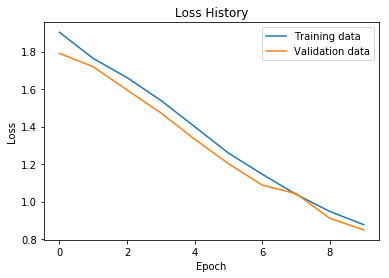

Asked: 347+855 True Value: 1202 Guessed Value: 1203 not equal
Asked: 20+917  True Value: 937  Guessed Value: 931  not equal
Asked: 68+974  True Value: 1042 Guessed Value: 1049 not equal
Asked: 91+244  True Value: 335  Guessed Value: 330  not equal
Asked: 158+6   True Value: 164  Guessed Value: 161  not equal
Asked: 5+470   True Value: 475  Guessed Value: 475  equal
Asked: 142+388 True Value: 530  Guessed Value: 531  not equal
Asked: 627+843 True Value: 1470 Guessed Value: 1473 not equal
Asked: 264+286 True Value: 550  Guessed Value: 541  not equal
Asked: 15+451  True Value: 466  Guessed Value: 461  not equal

--------------------------------------------------
Training Iteration 2 , Total 20 training


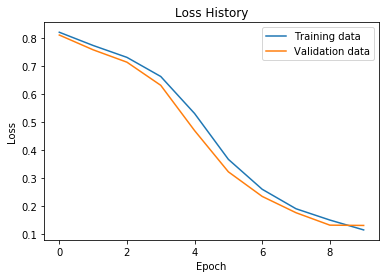

Asked: 932+493 True Value: 1425 Guessed Value: 1425 equal
Asked: 42+247  True Value: 289  Guessed Value: 289  equal
Asked: 825+46  True Value: 871  Guessed Value: 871  equal
Asked: 13+120  True Value: 133  Guessed Value: 133  equal
Asked: 395+41  True Value: 436  Guessed Value: 436  equal
Asked: 223+91  True Value: 314  Guessed Value: 314  equal
Asked: 175+64  True Value: 239  Guessed Value: 239  equal
Asked: 596+68  True Value: 664  Guessed Value: 664  equal
Asked: 273+34  True Value: 307  Guessed Value: 307  equal
Asked: 79+107  True Value: 186  Guessed Value: 186  equal

--------------------------------------------------
Training Iteration 3 , Total 30 training


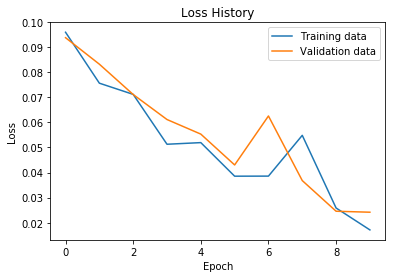

Asked: 27+672  True Value: 699  Guessed Value: 699  equal
Asked: 50+339  True Value: 389  Guessed Value: 389  equal
Asked: 142+871 True Value: 1013 Guessed Value: 1013 equal
Asked: 435+28  True Value: 463  Guessed Value: 463  equal
Asked: 336+896 True Value: 1232 Guessed Value: 1232 equal
Asked: 259+3   True Value: 262  Guessed Value: 262  equal
Asked: 628+78  True Value: 706  Guessed Value: 706  equal
Asked: 516+39  True Value: 555  Guessed Value: 555  equal
Asked: 483+822 True Value: 1305 Guessed Value: 1305 equal
Asked: 443+752 True Value: 1195 Guessed Value: 1195 equal

--------------------------------------------------
Training Iteration 4 , Total 40 training


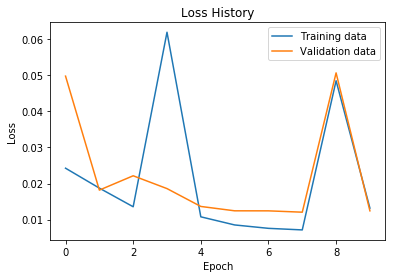

Asked: 91+640  True Value: 731  Guessed Value: 731  equal
Asked: 66+246  True Value: 312  Guessed Value: 312  equal
Asked: 418+802 True Value: 1220 Guessed Value: 1220 equal
Asked: 237+12  True Value: 249  Guessed Value: 249  equal
Asked: 492+8   True Value: 500  Guessed Value: 500  equal
Asked: 872+142 True Value: 1014 Guessed Value: 1014 equal
Asked: 28+513  True Value: 541  Guessed Value: 541  equal
Asked: 67+50   True Value: 117  Guessed Value: 117  equal
Asked: 470+687 True Value: 1157 Guessed Value: 1157 equal
Asked: 518+578 True Value: 1096 Guessed Value: 1096 equal

--------------------------------------------------
Training Iteration 5 , Total 50 training


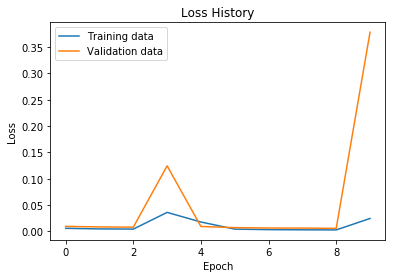

Asked: 740+51  True Value: 791  Guessed Value: 791  equal
Asked: 181+70  True Value: 251  Guessed Value: 251  equal
Asked: 175+703 True Value: 878  Guessed Value: 789  not equal
Asked: 39+523  True Value: 562  Guessed Value: 572  not equal
Asked: 18+67   True Value: 85   Guessed Value: 85   equal
Asked: 94+0    True Value: 94   Guessed Value: 94   equal
Asked: 11+450  True Value: 461  Guessed Value: 461  equal
Asked: 58+595  True Value: 653  Guessed Value: 644  not equal
Asked: 924+506 True Value: 1430 Guessed Value: 1441 not equal
Asked: 233+269 True Value: 502  Guessed Value: 502  equal

--------------------------------------------------
Training Iteration 6 , Total 60 training


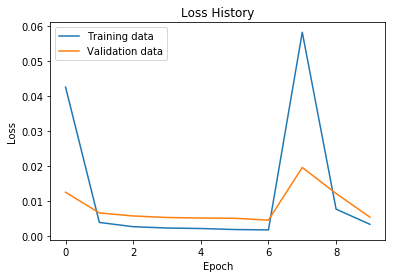

Asked: 807+31  True Value: 838  Guessed Value: 838  equal
Asked: 965+232 True Value: 1197 Guessed Value: 1197 equal
Asked: 627+10  True Value: 637  Guessed Value: 637  equal
Asked: 41+350  True Value: 391  Guessed Value: 391  equal
Asked: 298+19  True Value: 317  Guessed Value: 317  equal
Asked: 478+548 True Value: 1026 Guessed Value: 1026 equal
Asked: 88+943  True Value: 1031 Guessed Value: 1031 equal
Asked: 643+616 True Value: 1259 Guessed Value: 1259 equal
Asked: 635+17  True Value: 652  Guessed Value: 652  equal
Asked: 553+4   True Value: 557  Guessed Value: 557  equal

--------------------------------------------------
Training Iteration 7 , Total 70 training


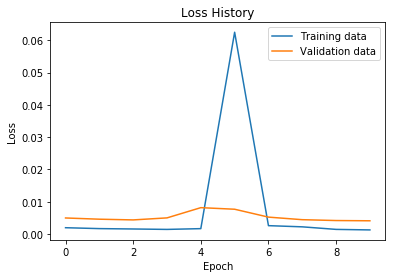

Asked: 25+179  True Value: 204  Guessed Value: 204  equal
Asked: 355+477 True Value: 832  Guessed Value: 832  equal
Asked: 729+834 True Value: 1563 Guessed Value: 1563 equal
Asked: 36+366  True Value: 402  Guessed Value: 402  equal
Asked: 45+34   True Value: 79   Guessed Value: 79   equal
Asked: 24+43   True Value: 67   Guessed Value: 67   equal
Asked: 201+438 True Value: 639  Guessed Value: 639  equal
Asked: 92+59   True Value: 151  Guessed Value: 151  equal
Asked: 1+438   True Value: 439  Guessed Value: 439  equal
Asked: 312+49  True Value: 361  Guessed Value: 361  equal

--------------------------------------------------
Training Iteration 8 , Total 80 training


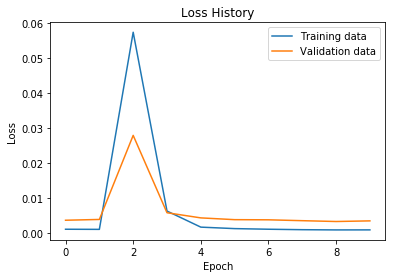

Asked: 699+730 True Value: 1429 Guessed Value: 1429 equal
Asked: 16+451  True Value: 467  Guessed Value: 467  equal
Asked: 66+16   True Value: 82   Guessed Value: 82   equal
Asked: 6+294   True Value: 300  Guessed Value: 300  equal
Asked: 28+409  True Value: 437  Guessed Value: 437  equal
Asked: 23+64   True Value: 87   Guessed Value: 87   equal
Asked: 41+567  True Value: 608  Guessed Value: 608  equal
Asked: 86+1    True Value: 87   Guessed Value: 87   equal
Asked: 344+10  True Value: 354  Guessed Value: 354  equal
Asked: 51+551  True Value: 602  Guessed Value: 602  equal

--------------------------------------------------
Training Iteration 9 , Total 90 training


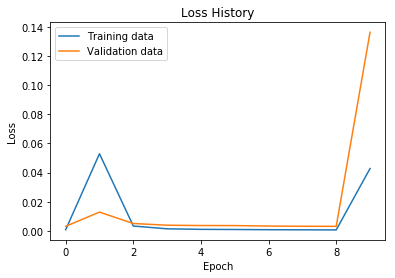

Asked: 284+5   True Value: 289  Guessed Value: 289  equal
Asked: 21+43   True Value: 64   Guessed Value: 64   equal
Asked: 344+433 True Value: 777  Guessed Value: 777  equal
Asked: 375+49  True Value: 424  Guessed Value: 424  equal
Asked: 48+473  True Value: 521  Guessed Value: 521  equal
Asked: 3+784   True Value: 787  Guessed Value: 787  equal
Asked: 7+909   True Value: 916  Guessed Value: 916  equal
Asked: 986+51  True Value: 1037 Guessed Value: 1037 equal
Asked: 1+10    True Value: 11   Guessed Value: 10   not equal
Asked: 653+67  True Value: 720  Guessed Value: 720  equal


In [7]:
# Train, Validate
# Graph Error
# Display Loss History
%matplotlib inline
import matplotlib.pyplot as plt
def plot_loss(history, title=None):
    # summarize history for loss
    if not isinstance(history, dict):
        history = history.history

    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    if title is not None:
        plt.title(title)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Training data', 'Validation data'], loc=0)
    plt.show()

batch_size = 128
nepochs = 10
iterations = 10
validation_size = 10
for iteration in range(1, iterations):
    history = model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=nepochs,
              validation_data=(x_test, y_test),
              verbose=0)
    
    # Random Validation Process
    print('\n' + ('-' * 50))
    print('Training Iteration', iteration, ', Total', iteration * nepochs, 'training')
    plot_loss(history, 'Loss History')
    for i in range(validation_size):
        indices = np.random.randint(0, len(x_test))
        rowx, rowy = x_test[np.array([indices])], y_test[np.array([indices])]

        preds = model.predict_classes(rowx, verbose=0)
        q = ctable.decode(rowx[0])
        correct = ctable.decode(rowy[0])
        guess = ctable.decode(preds[0], calc_argmax=False)
        print('Asked:', q[::-1] if REVERSE else q, end=' ')
        print('True Value:', correct, end=' ')
        print('Guessed Value:', guess, end=' ')
        if correct == guess: print('equal')
        else: print('not equal')